In [117]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# Simulation parameters
n_stocks = 100
n_quarters = 20
# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))  # Q0, Q1, ..., Q19

# Create full panel
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Simulate predictors
df["momentum"] = np.random.normal(0, 1, len(df))
df["volatility"] = np.random.normal(0, 1, len(df))

# Simulate Homogenous (Effects from predictors which do not depend on context)
hom_slope = 0.2

# Simulate Homogenous context predictors (Effects directly from context which do not depend on predictors)
stock_effects = {stock: np.random.normal(0, 0.5) for stock in stocks}
time_effects = {q: np.random.normal(0, 0.5) for q in quarters}

# Simulate Heterogenous predictor (Effects from predictors which are modulated by context)
stock_slopes = {stock: 0.5 + 0.3 * np.random.rand() for stock in stocks}


df["return"] = (
    df.apply(lambda row: stock_slopes[row["stock_id"]] * row["momentum"], axis=1)
    + hom_slope * df["volatility"]
    + df["stock_id"].map(stock_effects)
    + df["quarter"].map(time_effects)
    + np.random.normal(0, 0.3, len(df))
)

df.head(20)


,stock_id,quarter,momentum,volatility,return
0,Stock_0,0,0.496714,-0.675178,-0.975773
1,Stock_0,1,-0.138264,-0.144519,-1.123687
2,Stock_0,2,0.647689,-0.792420,0.635088
3,Stock_0,3,1.523030,-0.307962,0.037639
4,Stock_0,4,-0.234153,-1.893615,-1.244019
5,Stock_0,5,-0.234137,0.213294,-0.750506
6,Stock_0,6,1.579213,0.001205,0.323575
7,Stock_0,7,0.767435,-0.817089,0.397518
8,Stock_0,8,-0.469474,0.659246,-0.451793
9,Stock_0,9,0.542560,0.937570,-0.349728


In [118]:
# Use stock_id and quarter as context
context_df = df[["stock_id", "quarter"]].copy()
context_df["stock_id"] = context_df["stock_id"].astype("category").cat.codes  # encode as integers
context_df["quarter"] = context_df["quarter"].astype(int)

# Predictors
X = df[["momentum", "volatility"]].values
Y = df["return"].values.reshape(-1, 1)
C = context_df.values  # context = (stock_id, quarter)

In [119]:
# Convert to panel format
df = df.set_index(["stock_id", "quarter"])

# Run the fixed effects model
model = PanelOLS(
    dependent=df["return"],
    exog=df[["momentum", "volatility"]],
    entity_effects=True,
    time_effects=True
)
results = model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.8218
Estimator:                   PanelOLS   R-squared (Between):              0.1482
No. Observations:                2000   R-squared (Within):               0.5450
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.4365
Time:                        21:21:41   Log-likelihood                   -466.17
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4332.3
Entities:                         100   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(2,1879)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             1595.8
                            

In [120]:
# Predictions
df["predicted_return"] = results.predict().fitted_values
df_reset = df.reset_index()

df.head()

momentum  volatility    return  predicted_return
stock_id quarter                                                  
Stock_0  0        0.496714   -0.675178 -0.975773          0.200770
         1       -0.138264   -0.144519 -1.123687         -0.118254
         2        0.647689   -0.792420  0.635088          0.278297
         3        1.523030   -0.307962  0.037639          0.946200
         4       -0.234153   -1.893615 -1.244019         -0.509590

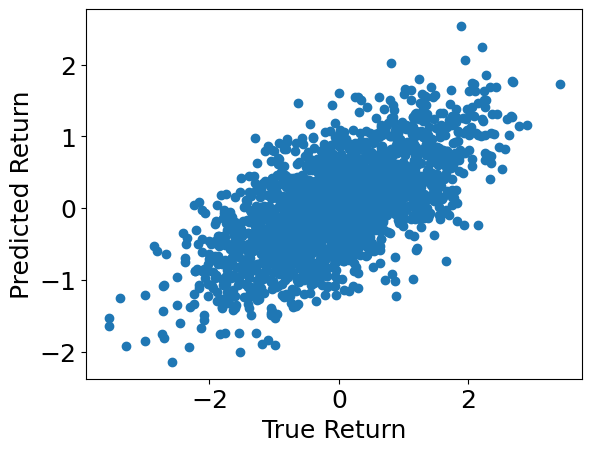

In [121]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(df['return'], df['predicted_return'])
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()

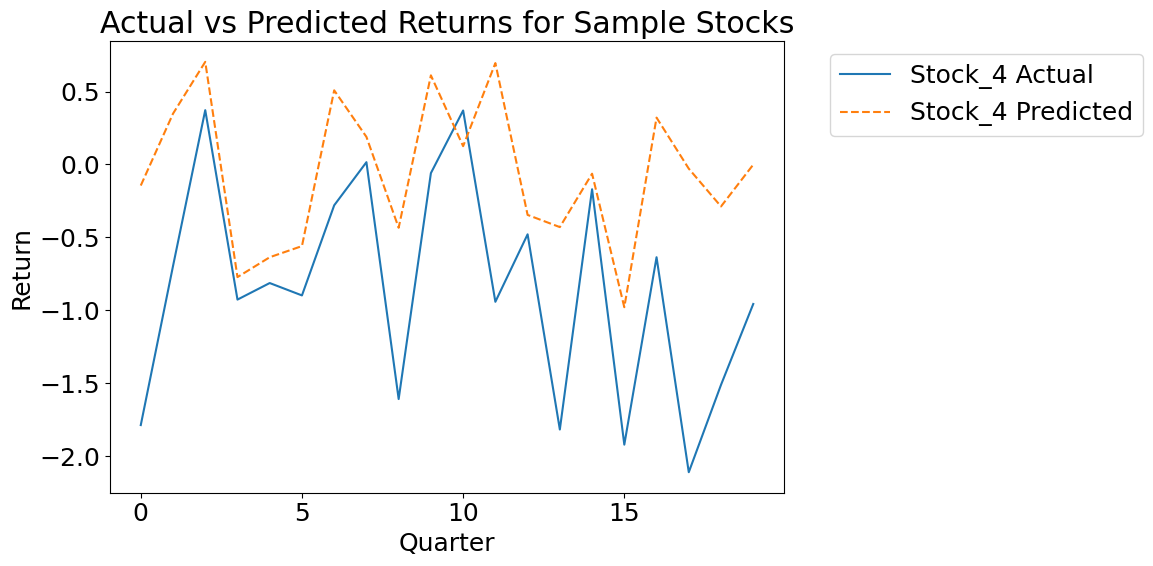

In [122]:
# Plot for first 5 stocks
fig, ax = plt.subplots(figsize=(12, 6))
sample_stocks = df_reset["stock_id"].unique()[4:5]

for stock in sample_stocks:
    stock_data = df_reset[df_reset["stock_id"] == stock]
    ax.plot(stock_data["quarter"], stock_data["return"], label=f"{stock} Actual", linestyle='-')
    ax.plot(stock_data["quarter"], stock_data["predicted_return"], label=f"{stock} Predicted", linestyle='--')

ax.set_title("Actual vs Predicted Returns for Sample Stocks")
ax.set_xlabel("Quarter")
ax.set_ylabel("Return")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [123]:
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# -------------------------------
# 1. Simulate the data
# -------------------------------

np.random.seed(42)

n_stocks = 100
n_periods = 20
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_periods))

index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Simulate predictors
df["momentum"] = np.random.normal(0, 1, len(df))
df["volatility"] = np.random.normal(0, 1, len(df))

# Simulate context-sensitive momentum slopes
stock_slopes = {stock: 0.5 + 0.3 * np.random.rand() for stock in stocks}
stock_effects = {stock: np.random.normal(0, 0.5) for stock in stocks}
time_effects = {q: np.random.normal(0, 0.5) for q in quarters}

df["return"] = (
    df.apply(lambda row: stock_slopes[row["stock_id"]] * row["momentum"], axis=1)
    + 0.2 * df["volatility"]
    + df["stock_id"].map(stock_effects)
    + df["quarter"].map(time_effects)
    + np.random.normal(0, 0.3, len(df))
)

# -------------------------------
# 2. Define context and predictors
# -------------------------------

# Use stock_id and quarter as context
context_df = df[["stock_id", "quarter"]].copy()
context_df["stock_id"] = context_df["stock_id"].astype("category").cat.codes  # encode as integers
context_df["quarter"] = context_df["quarter"].astype(int)

# Predictors
X = df[["momentum", "volatility"]].values
Y = df["return"].values.reshape(-1, 1)
C = context_df.values  # context = (stock_id, quarter)


In [124]:
# -------------------------------
# 3. Split and normalize
# -------------------------------

C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.2, random_state=42)

def normalize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    return (train - mean) / std, (test - mean) / std

X_train, X_test = normalize(X_train, X_test)
C_train, C_test = normalize(C_train, C_test)
Y_train, Y_test = normalize(Y_train, Y_test)

In [125]:
# -------------------------------
# 4. Train contextualised model
# -------------------------------

model = ContextualizedRegressor(n_bootstraps=20)
model.fit(C_train, X_train, Y_train,
          encoder_type="mlp",
          max_epochs=10,
          learning_rate=1e-2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/models/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 1.5 K  | train
-----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. 

RuntimeError: Early stopping conditioned on metric `val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`

In [ ]:
from contextualized.utils import save, load

save(model, path='contextualized_model_synthetic.pt')

In [ ]:
# -------------------------------
# 5. Extract learned coefficients
# -------------------------------

contextualized_coeffs, contextualized_offsets = model.predict_params(C_test)
Y_pred = model.predict(C_test, X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


array([[ 0.27992613],
       [-0.18295935],
       [-0.18222119],
       [ 0.26675374],
       [-0.38489946],
       [-0.18220981],
       [-0.18792325],
       [-0.20178072],
       [ 0.27546067],
       [ 0.27179988],
       [-0.18562143],
       [-0.1810794 ],
       [-0.18768748],
       [ 0.28465569],
       [-0.18398712],
       [-0.18381709],
       [ 0.26243186],
       [ 0.24994167],
       [ 0.23787127],
       [-0.1841243 ],
       [-0.18378421],
       [ 0.25336648],
       [ 0.26886995],
       [ 0.27913985],
       [ 0.26228145],
       [-0.18934123],
       [-0.18897414],
       [ 0.27410085],
       [-0.18131432],
       [-0.38763897],
       [ 0.27561984],
       [ 0.27460328],
       [-0.18193944],
       [ 0.25034938],
       [ 0.30476786],
       [-0.38180453],
       [-0.38839684],
       [-0.38172318],
       [-0.18769736],
       [-0.18301799],
       [ 0.26719661],
       [ 0.21293231],
       [-0.20912724],
       [ 0.27597618],
       [ 0.22154226],
       [ 0

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(Y_test, Y_pred)}')
print(f'Correlation: {r2_score(Y_test, Y_pred)}')

Mean-squared Error: 0.5665267209914426
Correlation: 0.4301317666894192


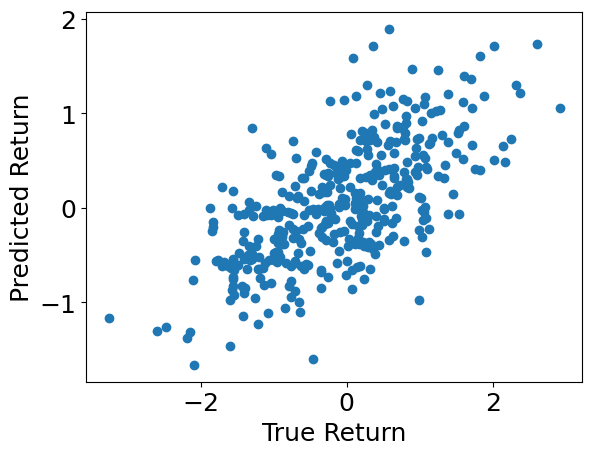

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y_test, Y_pred)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()

In [ ]:
%%capture
Y_preds = model.predict(C_test, X_test, individual_preds=True)
Y_preds.shape  # (n_bootstraps, n_samples, n_outputs)

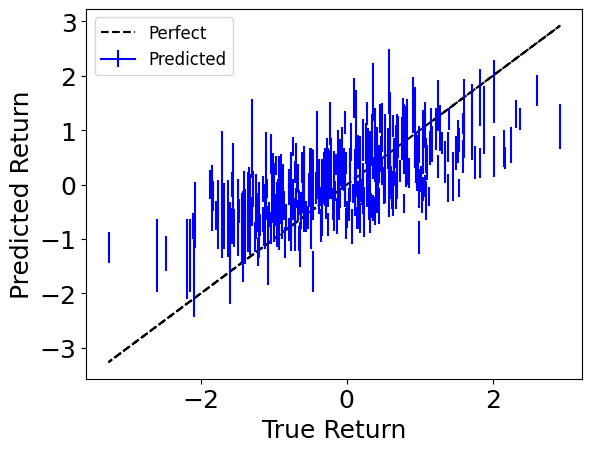

In [ ]:
# Squeeze the n_output dimension, we only have one output here.
Y_test = Y_test.squeeze()
Y_preds = Y_preds.squeeze()

plt.plot(Y_test, Y_test, color='black', linestyle='--', label='Perfect')
# Set the legend entry using the first datapoint. The rest will be the same.
plt.errorbar(Y_test[0], np.mean(Y_preds[:, 0], axis=0),
            yerr=2*np.std(Y_preds[:, 0], axis=0), color='blue',
            label='Predicted')
# Make scatter plot points with only error bars
for i in range(Y_preds.shape[1]):
    plt.errorbar(Y_test[i], np.mean(Y_preds[:, i], axis=0),
                yerr=2*np.std(Y_preds[:, i], axis=0), color='blue')
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.legend(fontsize=12)
plt.show()

In [ ]:
%%capture
coefs, offsets = model.predict_params(C, individual_preds=False)
coefs.shape # (n_samples, n_outputs, n_predictors)
offsets.shape  # (n_samples, n_outputs)

# Contextualized linear regression coefficients are shape:
# (n_samples, n_outputs, n_predictors)
# Let's squeeze out the n_outputs axis since we only have 1 output in this example.
coefs = np.squeeze(coefs)

'''# Any embedding method could be used; here we will use UMAP.
from umap import UMAP
um = UMAP(n_neighbors=5)
model_reps = um.fit_transform(coefs)'''


In [ ]:
from contextualized.analysis.embeddings import plot_embedding_for_all_covars
#plot_embedding_for_all_covars(coefs, C, xlabel='Model UMAP 1', ylabel='Model UMAP 2')
plot_embedding_for_all_covars(coefs, df[["stock_code", "quarter_code"]], xlabel='Model UMAP 1', ylabel='Model UMAP 2')


KeyError: "None of [Index(['stock_code', 'quarter_code'], dtype='object')] are in the [columns]"

In [ ]:
from contextualized.analysis.effects import (
    plot_homogeneous_context_effects,
    plot_homogeneous_predictor_effects,
    plot_heterogeneous_predictor_effects,
)

from contextualized.analysis.pvals import (
    calc_homogeneous_context_effects_pvals,
    calc_homogeneous_predictor_effects_pvals,
    calc_heterogeneous_predictor_effects_pvals
)

plot_homogeneous_context_effects(
    model, C_test, classification=False,
    ylabel="Diabetes Progression", verbose=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
# -------------------------------
# 6. Visualize momentum slope by stock
# -------------------------------

# Convert context back to stock IDs
decoded_context = pd.DataFrame(C_test, columns=["stock_id_norm", "quarter_norm"])
decoded_context["momentum_coef"] = contextualized_coeffs[:, 0]

# You can recover original stock IDs using inverse transform if needed.
# For now, we just group based on normalized stock index
stock_avg = decoded_context.groupby("stock_id_norm")["momentum_coef"].mean().reset_index()
stock_avg = stock_avg.sort_values(by="momentum_coef")

ValueError: Expected a 1D array, got an array with shape (400, 2)

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(stock_avg["stock_id_norm"], stock_avg["momentum_coef"])
plt.title("Average Learned Momentum Coefficient per Stock (ContextualisedML)")
plt.xlabel("Normalized Stock ID")
plt.ylabel("Momentum Coefficient")
plt.tight_layout()
plt.show()